# TruePeakDetector use example

This algorithm implements the “true-peak” level meter as descripted in the second annex of the ITU-R BS.1770-2[1] or the ITU-R BS.1770-4[2] (default).
    
    Note: the parameters 'blockDC' and 'emphatise' work only when 'version' is set to 2.

        References:
        [1] Series, B. S. (2011). Recommendation  ITU-R  BS.1770-2. Algorithms to
        measure audio programme loudness and true-peak audio level,
        https://www.itu.int/dms_pubrec/itu-r/rec/bs/R-REC-BS.1770-2-201103-S!!PDF-E.
        pdfe  
        [2] Series, B. S. (2011). Recommendation  ITU-R  BS.1770-4. Algorithms
        to measure audio programme loudness and true-peak audio level,
        https://www.itu.int/dms_pubrec/itu-r/rec/bs/R-REC-BS.1770-4-201510-I!!PDF-E.
        pdf

In [1]:
import essentia.standard as es
import numpy as np
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import ipywidgets as wg
from IPython.display import Audio 
from essentia import array as esarr

plt.rcParams["figure.figsize"] =(9, 5)

# The problem of true peak estimation
The following widget demonstrates two intersample detection techniques:
- **Signal upsampling.** 
- **parabolic interpolation.** 

The accuracy of both methods can be assessed in real-time by shifting the sampling points in a  Sinc function and evaluating the error produced by both systems.

In [5]:
# Parameters

duration = 10 # s
fs = 1 # hz 
k = 1. # amplitude
oversamplingFactor = 4 # factor of oversampling for the real signal
nSamples = fs * duration

time = np.arange(-nSamples/2, nSamples/2,
                 2 ** -oversamplingFactor, dtype='float')
samplingPoints = time[::2 ** oversamplingFactor]

def shifted_sinc(x, k, offset):
    xShifted = x - offset
    y = np.zeros(len(xShifted))
    for idx, i in enumerate(xShifted):
        if not i: 
            y[idx] = k
        else:
            y[idx] = (k * np.sin(np.pi * i) / (np.pi * i))
    return y

def resampleStrategy(y, fs, quality=0, oversampling=4):
    yResample = es.Resample(inputSampleRate=fs,
                            outputSampleRate=fs*oversampling, 
                            quality=quality)(y.astype(np.float32))
    
    tResample = np.arange(np.min(samplingPoints), np.max(samplingPoints) 
                          + 1, 1. / (fs * oversampling))
    tResample = tResample[:len(yResample)]        
    
    # getting the stimated peaks
    yResMax = np.max(yResample)
    tResMax = tResample[np.argmax(yResample)]
    
    return yResample, tResample, yResMax, tResMax

def parabolicInterpolation(y, threshold=.6):
    # todo plot the parabol maybe
    positions, amplitudes = es.PeakDetection(threshold=threshold)\
                                        (y.astype(np.float32))
       
    pos = int(positions[0] * (len(y-1)))
    a = y[pos - 1]
    b = y[pos]
    c = y[pos + 1]

    tIntMax = samplingPoints[pos] + (a - c) / (2 * (a - 2 * b + c))
    yIntMax = b - ((a - b) ** 2) / (8 * (a - 2 * b + c))
    return tIntMax, yIntMax

def process():
    
    ## Processing
    
    # "real" sinc
    yReal = shifted_sinc(time, k, offset.value)
    
    # sampled sinc
    y = shifted_sinc(samplingPoints, k, offset.value)
    
    
    # Resample strategy
    yResample, tResample, yResMax, tResMax = \
        resampleStrategy(y, fs, quality=0, oversampling=4)
    
    # Parabolic Interpolation extrategy
    tIntMax, yIntMax = parabolicInterpolation(y)
    
    
    
    ## Plotting
    ax.clear()
    plt.title('Interpeak detection estrategies')
    ax.grid(True)
    ax.grid(xdata=samplingPoints)
    
    
    ax.plot(time, yReal, label='real signal')
    yRealMax = np.max(yReal)
    
    sampledLabel = 'sampled signal. Error:{:.3f}'\
                   .format(np.abs(np.max(y) - yRealMax))
    ax.plot(samplingPoints, y, label=sampledLabel, ls='-.',
         color='r', marker='x', markersize=6, alpha=.7)

    ax.plot(tResample, yResample, ls='-.',
                 color='y', marker='x', alpha=.7)

    resMaxLabel = 'Resample Peak. Error:{:.3f}'\
                  .format(np.abs(yResMax - yRealMax))
    ax.plot(tResMax, yResMax, label= resMaxLabel, 
            color='y', marker = 'x', markersize=12)

    intMaxLabel = 'Interpolation Peak. Error:{:.3f}'\
                  .format(np.abs(yIntMax - yRealMax))
    ax.plot(tIntMax, yIntMax, label= intMaxLabel, 
            marker = 'x', markersize=12)
    
    
    fig.legend()
    fig.show()

FloatSlider(value=0.0, max=1.0, min=-1.0)

<IPython.core.display.Javascript object>


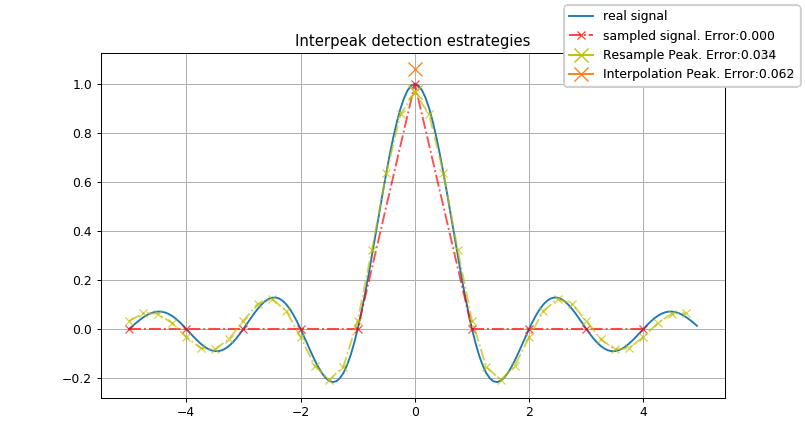

In [6]:
# matplotlib.use('TkAgg')
offset = wg.FloatSlider()
offset.max = 1
offset.min = -1
offset.step = .1
display(offset)
fig, ax = plt.subplots()
process()

def on_value_change(change):
    process()
    
offset.observe(on_value_change, names='value')

As it can be seen from the widget, the oversampling strategy generates a smaller error in most of the cases.

# The ITU-R BS.1770 approach

The ITU-R BS.1770 recommentation proposess the following signal chain based on the oversampling strategy:
        
        -12.04dB --> x4 oversample --> LowPass --> abs() --> 20 * log10() --> +12.04dB
        
In our implementation, the gain control is suppressed from the chain as in not required when working with float point values, and the result is returned in natural units as it can be converted to dB as a postprocessing step. Here we can see an example.

<IPython.core.display.Javascript object>


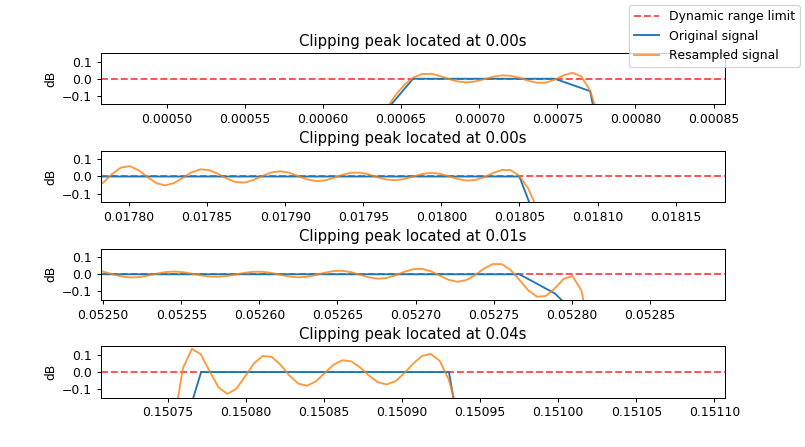

In [4]:
fs = 44100.
eps = np.finfo(np.float32).eps
audio_dir = '../../audio/'
audio = es.MonoLoader(filename='{}/{}'.format(audio_dir,
                      'recorded/distorted.wav'),
                      sampleRate=fs)()

times = np.linspace(0, len(audio) / fs, len(audio))

peakLocations, output = es.TruePeakDetector(version=2)(audio)

oversampledtimes = np.linspace(0, len(output) / (fs*4), len(output))

random_indexes = [1, 300, 1000, 3000]

figu, axes = plt.subplots(len(random_indexes))
plt.subplots_adjust(hspace=.9)
for idx, ridx in enumerate(random_indexes):
    l0 = axes[idx].axhline(0, color='r', alpha=.7, ls = '--')
    l1 = axes[idx].plot(times, 20 * np.log10(np.abs(audio + eps)))
    l2 = axes[idx].plot(oversampledtimes, 20 * np.log10(output + eps), alpha=.8)
    
    axes[idx].set_xlim([peakLocations[ridx]  / fs - .0002, peakLocations[ridx] / fs + .0002])
    axes[idx].set_ylim([-.15, 0.15])
    axes[idx].set_title('Clipping peak located at {:.2f}s'.format(peakLocations[ridx]  / (fs*4)))
    axes[idx].set_ylabel('dB')
    
figu.legend([l0, l1[-1], l2[-1]], ['Dynamic range limit', 'Original signal', 'Resampled signal'])
plt.show()

The resampled signal is closer to the analog signal once it goes through the DAC. The part of this signal peaking above 1 may produce additional distortion if the analog amplifier doesn't have enough headroom to handle this additional amplitude. As this type of distortion depends entirely on the design of the playback hardware, it is always recommended to produce music so the true peak positions never overcome the dynamic range [-1, 1].

# The parameters
this is an explanation of the most relevant parameters of the algorithm

- **oversamplingFactor.** How many times to resample the signal

- **version.** Version of the recommendation to use. Read the references to understand the differences

- **blockDC and emphatise.** Optional post-processing on the 2nd version of the recommendation. blockDC is a very low-frequency high pass filter and emphatise is a high-shelf filter. 
